# **Extracting Information from Legal Documents Using RAG**

## **Objective**

The main objective of this assignment is to process and analyse a collection text files containing legal agreements (e.g., NDAs) to prepare them for implementing a **Retrieval-Augmented Generation (RAG)** system. This involves:

* Understand the Cleaned Data : Gain a comprehensive understanding of the structure, content, and context of the cleaned dataset.
* Perform Exploratory Analysis : Conduct bivariate and multivariate analyses to uncover relationships and trends within the cleaned data.
* Create Visualisations : Develop meaningful visualisations to support the analysis and make findings interpretable.
* Derive Insights and Conclusions : Extract valuable insights from the cleaned data and provide clear, actionable conclusions.
* Document the Process : Provide a detailed description of the data, its attributes, and the steps taken during the analysis for reproducibility and clarity.

The ultimate goal is to transform the raw text data into a clean, structured, and analysable format that can be effectively used to build and train a RAG system for tasks like information retrieval, question-answering, and knowledge extraction related to legal agreements.

### **Business Value**  


The project aims to leverage RAG to enhance legal document processing for businesses, law firms, and regulatory bodies. The key business objectives include:

* Faster Legal Research: <br> Reduce the time lawyers and compliance officers spend searching for relevant case laws, precedents, statutes, or contract clauses.
* Improved Contract Analysis: <br> Automatically extract key terms, obligations, and risks from lengthy contracts.
* Regulatory Compliance Monitoring: <br> Help businesses stay updated with legal and regulatory changes by retrieving relevant legal updates.
* Enhanced Decision-Making: <br> Provide accurate and context-aware legal insights to assist in risk assessment and legal strategy.


**Use Cases**
* Legal Chatbots
* Contract Review Automation
* Tracking Regulatory Changes and Compliance Monitoring
* Case Law Analysis of past judgments
* Due Diligence & Risk Assessment

## **1. Data Loading, Preparation and Analysis** <font color=red> [20 marks] </font><br>

### **1.1 Data Understanding**

The dataset contains legal documents and contracts collected from various sources. The documents are present as text files (`.txt`) in the *corpus* folder.

There are four types of documents in the *courpus* folder, divided into four subfolders.
- `contractnli`: contains various non-disclosure and confidentiality agreements
- `cuad`: contains contracts with annotated legal clauses
- `maud`: contains various merger/acquisition contracts and agreements
- `privacy_qa`: a question-answering dataset containing privacy policies

The dataset also contains evaluation files in JSON format in the *benchmark* folder. The files contain the questions and their answers, along with sources. For each of the above four folders, there is a `json` file: `contractnli.json`, `cuad.json`, `maud.json` `privacy_qa.json`. The file structure is as follows:

```
{
    "tests": [
        {
            "query": <question1>,
            "snippets": [{
                    "file_path": <source_file1>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 1>
                },
                {
                    "file_path": <source_file2>,
                    "span": [ begin_position, end_position ],
                    "answer": <relevant answer to the question 2>
                }, ....
            ]
        },
        {
            "query": <question2>,
            "snippets": [{<answer context for que 2>}]
        },
        ... <more queries>
    ]
}
```

### **1.2 Load and Preprocess the data** <font color=red> [5 marks] </font><br>

#### Loading libraries

In [1]:
## The following libraries might be useful
!pip install -q langchain-openai
!pip install -U -q langchain-community
!pip install -U -q langchain-chroma
!pip install -U -q datasets
!pip install -U -q ragas
!pip install -U -q rouge_score

In [ ]:
# Import essential libraries

import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from transformers import GPT2TokenizerFast
import warnings
warnings.filterwarnings('ignore')

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# LangChain imports
from langchain_core.documents import Document
from langchain_community.document_loaders import DirectoryLoader, TextLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI

# Evaluation imports
from rouge_score import rouge_scorer
from datasets import Dataset
import ragas
from ragas.metrics import faithfulness, answer_relevancy, context_precision, context_recall
from ragas import evaluate

#### **1.2.1** <font color=red> [3 marks] </font>
Load all `.txt` files from the folders.

You can utilise document loaders from the options provided by the LangChain community.

Optionally, you can also read the files manually, while ensuring proper handling of encoding issues (e.g., utf-8, latin1). In such case, also store the file content along with metadata (e.g., file name, directory path) for traceability.

In [3]:
def load_documents_from_directory(directory_path):
    """
    Load all text documents from a directory and its subdirectories
    """
    documents = []
    
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            if file.endswith('.txt'):
                file_path = os.path.join(root, file)
                try:
                    # Try different encodings
                    for encoding in ['utf-8', 'latin-1']:
                        try:
                            with open(file_path, 'r', encoding=encoding) as f:
                                content = f.read()
                            break
                        except UnicodeDecodeError:
                            continue
                    else:
                        print(f"Could not decode file: {file_path}")
                        continue
                    
                    # Store document with metadata
                    documents.append({
                        'content': content,
                        'source': file_path,
                        'filename': file,
                        'directory': os.path.basename(root)
                    })
                except Exception as e:
                    print(f"Error reading file {file_path}: {str(e)}")
    
    return documents

# Load the files as documents
corpus_path = "rag_legal/corpus"
all_documents = load_documents_from_directory(corpus_path)

print(f"Loaded {len(all_documents)} documents")
print(f"Sample document keys: {list(all_documents[0].keys()) if all_documents else 'No documents found'}")

Loaded 698 documents
Sample document keys: ['content', 'source', 'filename', 'directory']


#### **1.2.2** <font color=red> [2 marks] </font>
Preprocess the text data to remove noise and prepare it for analysis.

Remove special characters, extra whitespace, and irrelevant content such as email and telephone contact info.
Normalise text (e.g., convert to lowercase, remove stop words).
Handle missing or corrupted data by logging errors and skipping problematic files.

In [ ]:
# Clean and preprocess the data

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\S+@\S+', '', text)  
    text = re.sub(r'(\+?\d{1,3}[-.\s]?)?\(?\d{3}\)?[-.\s]?\d{3}[-.\s]?\d{4}', '', text)  
    text = re.sub(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', text) 
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\n+', '\n', text)
    text = re.sub(r'[^\w\s\.,;:!?()-]', ' ', text)
    text = re.sub(r'[.]{2,}', '.', text)
    text = re.sub(r'[-]{2,}', '-', text)
    text = re.sub(r'\b(\d+\.\d+(\.\d+)*)\b', r'\1', text) 
    return text.strip()

In [5]:
def normalize_text(text, remove_stopwords=False):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    lemmatizer = WordNetLemmatizer()
    if remove_stopwords:
        stop_words = set(stopwords.words('english') + [
            'shall', 'herein', 'thereof', 'whereas', 'agreement', 'party',
            'therein', 'whereby', 'aforementioned', 'pursuant', 'clause', 'section',
            'hereunder', 'thereunder', 'aforesaid'
        ])
        word_tokens = word_tokenize(text)
        text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens if word not in stop_words and len(word) > 2])
    else:
        word_tokens = word_tokenize(text)
        text = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])
    return text

In [6]:
cleaned_documents = []
failed_documents = []
for doc in all_documents:
    try:
        cleaned_content = clean_text(doc['content'])
        if len(cleaned_content.strip()) > 0:
            cleaned_doc = doc.copy()
            cleaned_doc['content'] = cleaned_content
            cleaned_doc['normalized_content'] = normalize_text(cleaned_content, remove_stopwords=True)
            cleaned_doc['word_count'] = len(cleaned_content.split())
            cleaned_doc['sentences'] = sent_tokenize(cleaned_content) 
            cleaned_documents.append(cleaned_doc)
        else:
            failed_documents.append(doc['source'])
    except Exception as e:
        print(f"Error processing document {doc['source']}: {str(e)}")
        failed_documents.append(doc['source'])

print(f"Successfully processed {len(cleaned_documents)} documents")
print(f"Failed to process {len(failed_documents)} documents")
if failed_documents:
    print(f"Failed documents: {failed_documents[:5]}...")

Successfully processed 698 documents
Failed to process 0 documents


### **1.3 Exploratory Data Analysis** <font color=red> [10 marks] </font><br>

#### **1.3.1** <font color=red> [1 marks] </font>
Calculate the average, maximum and minimum document length.

In [7]:
# Calculate the average, maximum and minimum document length.

word_counts = [doc['word_count'] for doc in cleaned_documents]
char_counts = [len(doc['content']) for doc in cleaned_documents]

avg_words = np.mean(word_counts)
max_words = np.max(word_counts)
min_words = np.min(word_counts)

avg_chars = np.mean(char_counts)
max_chars = np.max(char_counts)
min_chars = np.min(char_counts)

print("Document Length Statistics:")
print(f"Word Count - Average: {avg_words:.2f}, Maximum: {max_words}, Minimum: {min_words}")
print(f"Character Count - Average: {avg_chars:.2f}, Maximum: {max_chars}, Minimum: {min_chars}")

Document Length Statistics:
Word Count - Average: 16188.21, Maximum: 157239, Minimum: 228
Character Count - Average: 102260.68, Maximum: 985272, Minimum: 1389


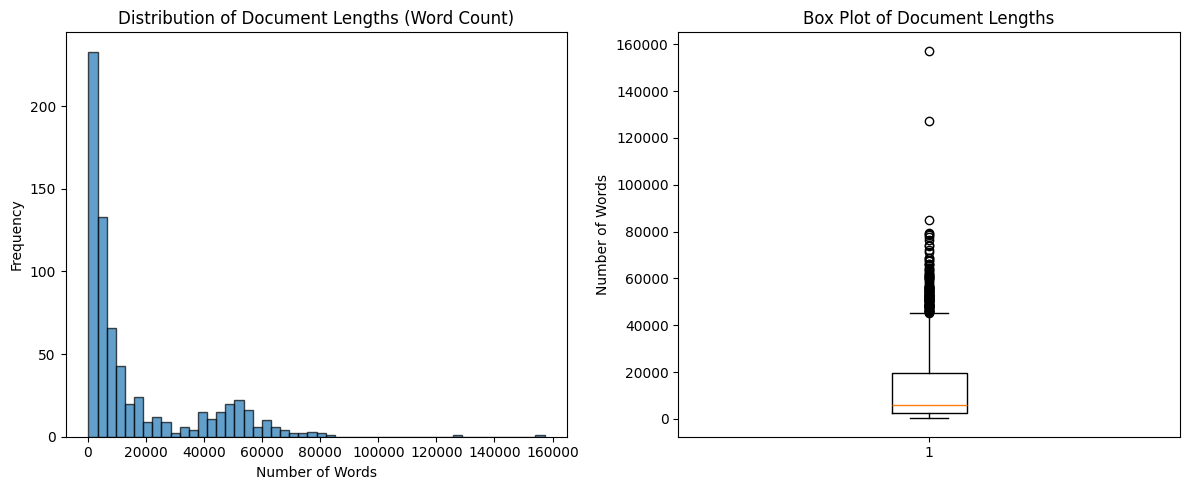

In [8]:
# Visualize document length distribution

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(word_counts, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Document Lengths (Word Count)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(word_counts)
plt.title('Box Plot of Document Lengths')
plt.ylabel('Number of Words')

plt.tight_layout()
plt.show()

#### **1.3.2** <font color=red> [4 marks] </font>
Analyse the frequency of occurrence of words and find the most and least occurring words.

Find the 20 most common and least common words in the text. Ignore stop words such as articles and prepositions.

In [9]:
def get_word_frequencies(documents, remove_stopwords=True):
    """
    Calculate word frequencies across all documents
    """
    all_text = ' '.join([doc['normalized_content'] for doc in documents])
    
    # Tokenize
    words = word_tokenize(all_text)
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        words = [word for word in words if word.lower() not in stop_words and len(word) > 2 and word.isalpha()]
    else:
        words = [word for word in words if len(word) > 2 and word.isalpha()]
    
    return Counter(words)

In [10]:
# Find frequency of occurence of words
word_freq = get_word_frequencies(cleaned_documents)
total_unique_words = len(word_freq)
total_words = sum(word_freq.values())

print(f"Total unique words: {total_unique_words}")
print(f"Total words: {total_words}")

# Get most and least common words
most_common_20 = word_freq.most_common(20)
least_common_20 = word_freq.most_common()[-20:]

print("\n20 Most Common Words:")
for word, count in most_common_20:
    print(f"{word}: {count}")

print("\n20 Least Common Words:")
for word, count in least_common_20:
    print(f"{word}: {count}")


Total unique words: 25046
Total words: 5402935

20 Most Common Words:
company: 157988
parent: 60711
subsidiary: 46064
date: 40405
material: 39082
time: 36939
merger: 35340
respect: 33676
right: 32403
applicable: 31371
law: 29891
including: 29404
may: 28069
share: 27801
term: 27704
stock: 26673
information: 25713
business: 25280
party: 24618
prior: 23342

20 Least Common Words:
deltadna: 1
aerserv: 1
applovin: 1
chartboost: 1
fyber: 1
heyzap: 1
hyprmx: 1
inmobi: 1
ironsource: 1
kongregate: 1
lifestreet: 1
loopme: 1
nativex: 1
pinsight: 1
smaato: 1
soomla: 1
tapjoy: 1
tapresearch: 1
vungle: 1
newer: 1


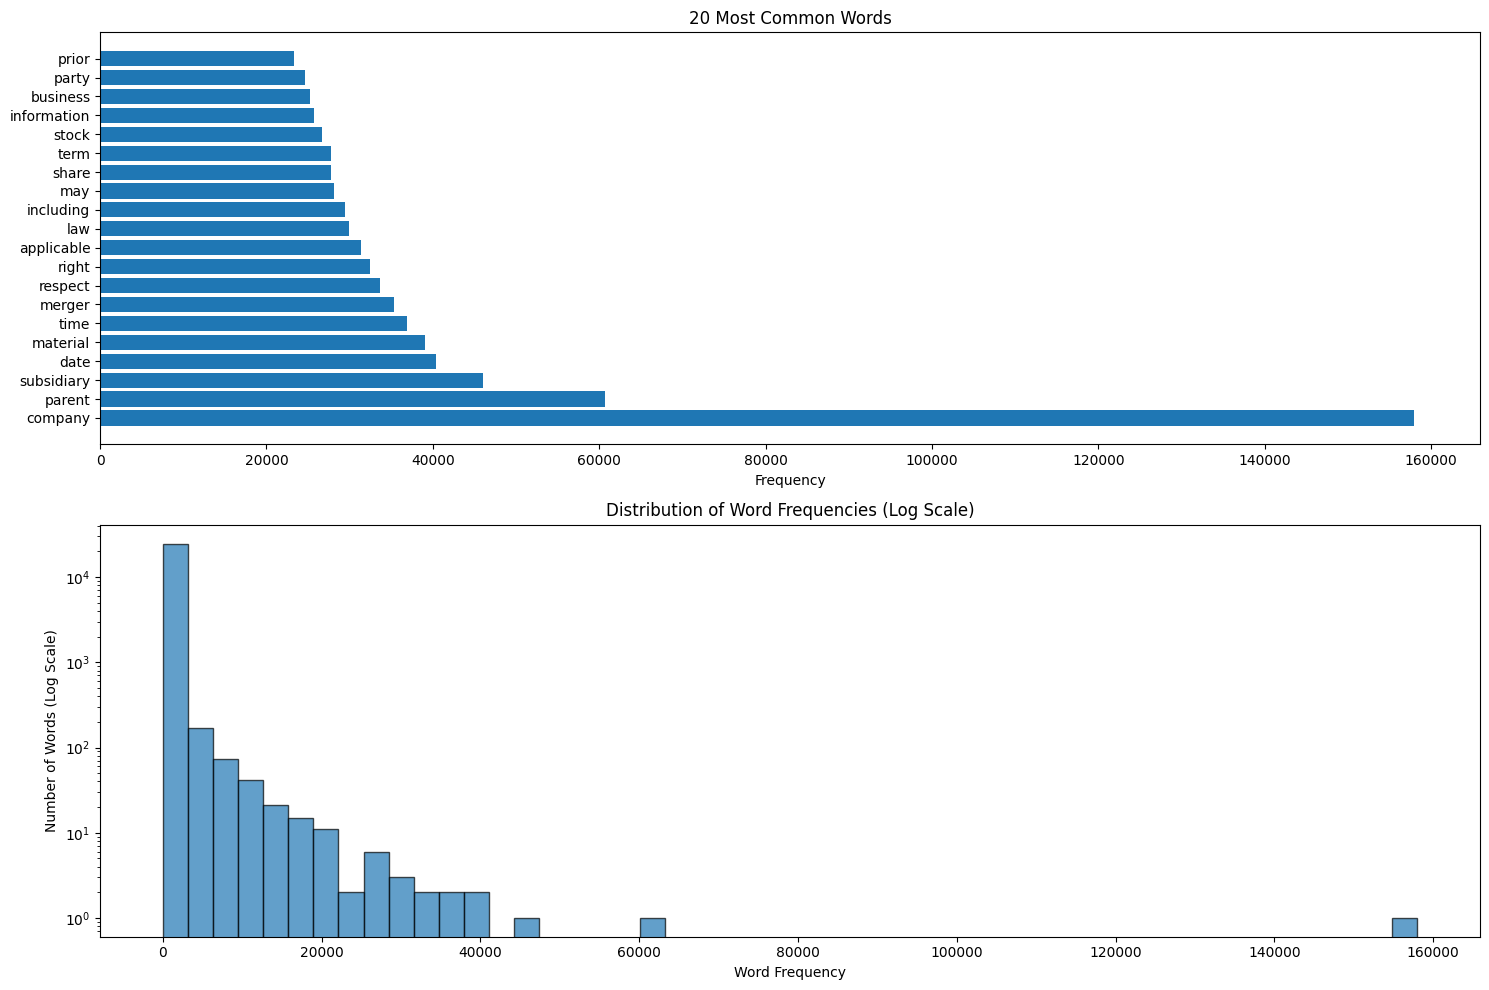

In [11]:
plt.figure(figsize=(15, 10))

# Most common words
plt.subplot(2, 1, 1)
words_most = [item[0] for item in most_common_20]
counts_most = [item[1] for item in most_common_20]
plt.barh(words_most, counts_most)
plt.title('20 Most Common Words')
plt.xlabel('Frequency')

# Word frequency distribution
plt.subplot(2, 1, 2)
freq_counts = list(word_freq.values())
plt.hist(freq_counts, bins=50, log=True, alpha=0.7, edgecolor='black')
plt.title('Distribution of Word Frequencies (Log Scale)')
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words (Log Scale)')

plt.tight_layout()
plt.show()

#### **1.3.3** <font color=red> [4 marks] </font>
Analyse the similarity of different documents to each other based on TF-IDF vectors.

Transform some documents to TF-IDF vectors and calculate their similarity matrix using a suitable distance function. If contracts contain duplicate or highly similar clauses, similarity calculation can help detect them.

Identify for the first 10 documents and then for 10 random documents. What do you observe?

In [12]:
def calculate_document_similarity(documents, n_docs=10):
    """
    Calculate TF-IDF similarity between documents
    """
    # Prepare document texts
    doc_texts = [doc['content'] for doc in documents[:n_docs]]
    
    # Create TF-IDF vectorizer
    vectorizer = TfidfVectorizer(
        max_features=1000,
        stop_words='english',
        lowercase=True,
        ngram_range=(1, 2)
    )
    
    # Transform documents to TF-IDF vectors
    tfidf_matrix = vectorizer.fit_transform(doc_texts)
    
    # Calculate cosine similarity matrix
    similarity_matrix = cosine_similarity(tfidf_matrix)
    
    return similarity_matrix, [doc['filename'] for doc in documents[:n_docs]]

In [13]:
# Transform the page contents of documents
print("Analyzing similarity for first 10 documents:")
similarity_matrix_first10, doc_names_first10 = calculate_document_similarity(cleaned_documents, 10)

print(f"Similarity matrix shape: {similarity_matrix_first10.shape}")

# Compute similarity scores
print("Average similarity (excluding diagonal):")
mask = np.ones_like(similarity_matrix_first10, dtype=bool)
np.fill_diagonal(mask, 0)
avg_similarity_first10 = similarity_matrix_first10[mask].mean()
print(f"First 10 documents: {avg_similarity_first10:.4f}")

Analyzing similarity for first 10 documents:
Similarity matrix shape: (10, 10)
Average similarity (excluding diagonal):
First 10 documents: 0.5313


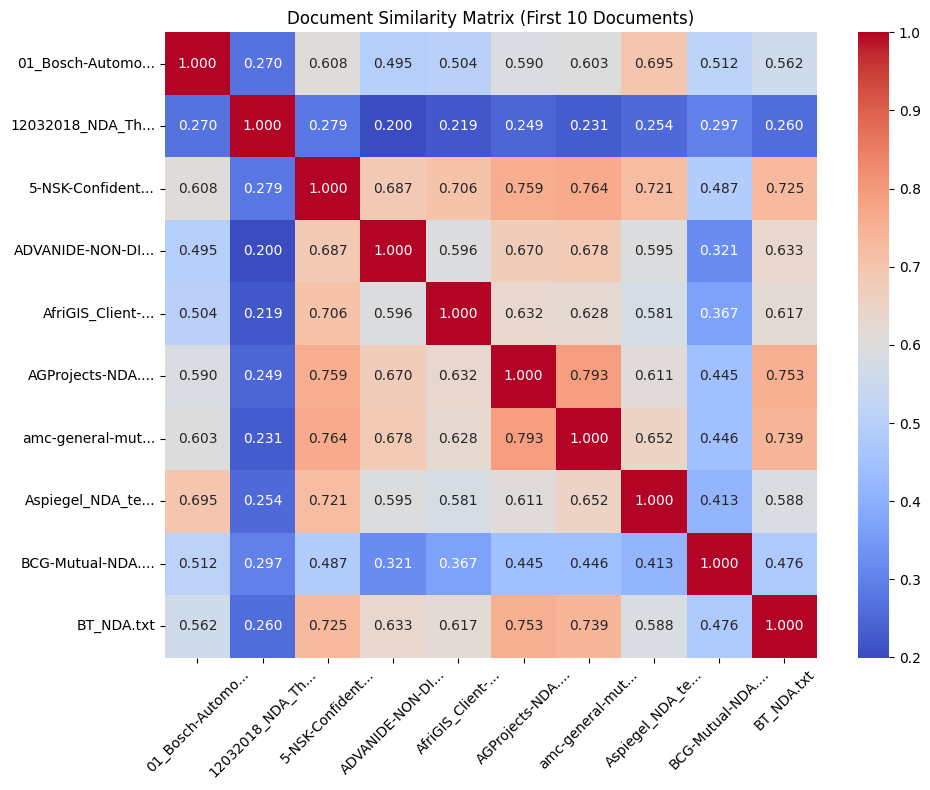

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_first10, 
            xticklabels=[name[:15] + '...' if len(name) > 15 else name for name in doc_names_first10],
            yticklabels=[name[:15] + '...' if len(name) > 15 else name for name in doc_names_first10],
            annot=True, fmt='.3f', cmap='coolwarm')
plt.title('Document Similarity Matrix (First 10 Documents)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
# create a list of 10 random integers
np.random.seed(42) 
random_indices = np.random.choice(len(cleaned_documents), size=10, replace=False)
print(f"Random document indices: {random_indices}")

Random document indices: [158 499 396 155 321 212 234 289 300 356]


In [16]:
# Compute similarity scores for 10 random documents
print("\nAnalyzing similarity for 10 random documents:")
random_documents = [cleaned_documents[i] for i in random_indices]
similarity_matrix_random, doc_names_random = calculate_document_similarity(random_documents, 10)

avg_similarity_random = similarity_matrix_random[mask].mean()
print(f"Random 10 documents: {avg_similarity_random:.4f}")



Analyzing similarity for 10 random documents:
Random 10 documents: 0.1674


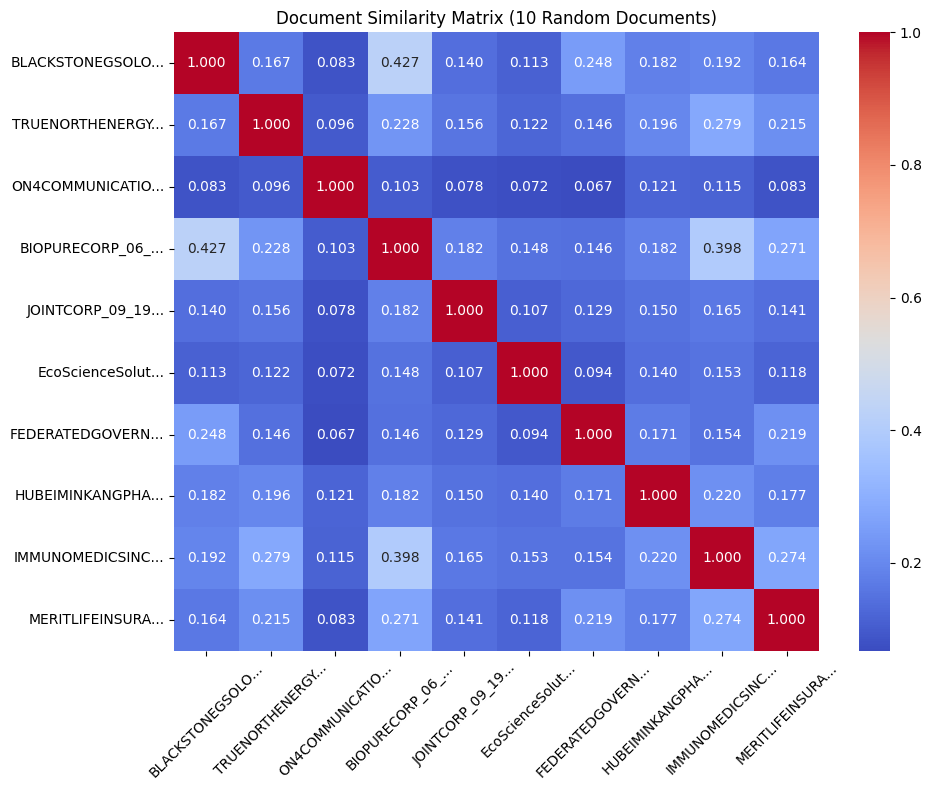


Observations:
Average similarity (first 10): 0.5313
Average similarity (random 10): 0.1674
Higher similarity values indicate more similar document content.
Legal documents often show moderate similarity due to standard legal language and clauses.


In [17]:
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix_random,
            xticklabels=[name[:15] + '...' if len(name) > 15 else name for name in doc_names_random],
            yticklabels=[name[:15] + '...' if len(name) > 15 else name for name in doc_names_random],
            annot=True, fmt='.3f', cmap='coolwarm')
plt.title('Document Similarity Matrix (10 Random Documents)')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nObservations:")
print(f"Average similarity (first 10): {avg_similarity_first10:.4f}")
print(f"Average similarity (random 10): {avg_similarity_random:.4f}")
print("Higher similarity values indicate more similar document content.")
print("Legal documents often show moderate similarity due to standard legal language and clauses.")

### **1.4 Document Creation and Chunking** <font color=red> [5 marks] </font><br>

#### **1.4.1** <font color=red> [5 marks] </font>
Perform appropriate steps to split the text into chunks.

In [18]:
# Process files and generate chunks
def create_langchain_documents(cleaned_documents):
    """
    Convert our document format to LangChain Document format
    """
    from langchain.schema import Document
    
    langchain_docs = []
    for doc in cleaned_documents:
        langchain_doc = Document(
            page_content=doc['content'],
            metadata={
                'source': doc['source'],
                'filename': doc['filename'],
                'directory': doc['directory'],
                'word_count': doc['word_count']
            }
        )
        langchain_docs.append(langchain_doc)
    
    return langchain_docs

print("Creating LangChain documents...")
langchain_documents = create_langchain_documents(cleaned_documents)


Creating LangChain documents...


In [ ]:
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=512,  
    chunk_overlap=50,  
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""] 
)

print("Splitting documents into chunks...")
chunks = text_splitter.split_documents(langchain_documents)

print(f"Created {len(chunks)} chunks from {len(langchain_documents)} documents")

Splitting documents into chunks...
Created 194009 chunks from 698 documents


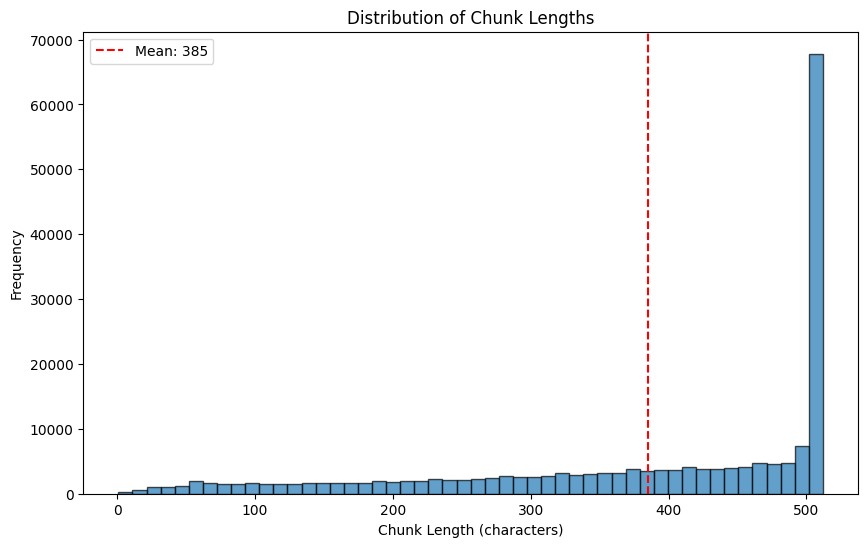

In [20]:
# Visualize chunk distribution
chunk_lengths = [len(chunk.page_content) for chunk in chunks]

plt.figure(figsize=(10, 6))
plt.hist(chunk_lengths, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Chunk Lengths')
plt.xlabel('Chunk Length (characters)')
plt.ylabel('Frequency')
plt.axvline(np.mean(chunk_lengths), color='red', linestyle='--', label=f'Mean: {np.mean(chunk_lengths):.0f}')
plt.legend()
plt.show()

In [21]:
print("\nSample chunks:")
for i, chunk in enumerate(chunks[:3]):
    print(f"\nChunk {i+1} (from {chunk.metadata['filename']}):")
    print(f"Length: {len(chunk.page_content)} characters")
    print(f"Content preview: {chunk.page_content[:200]}...")


Sample chunks:

Chunk 1 (from 01_Bosch-Automotive-Service-Solutions-Mutual-Non-Disclosure-Agreement-7-12-17.txt):
Length: 456 characters
Content preview: MUTUAL NON-DISCLOSURE AGREEMENT Between AND Subject Matter: Effective Date of Agreement: Period , 2017 for Exchange of Information: , 2017 to Period of Confidentiality: THIS AGREEMENT is made as of th...

Chunk 2 (from 01_Bosch-Automotive-Service-Solutions-Mutual-Non-Disclosure-Agreement-7-12-17.txt):
Length: 380 characters
Content preview: . The parties may extend the Subject Matter or add additional parties by executing one or more addenda to this Agreement. II. Such discussions may involve disclosure by one party to the other party of...

Chunk 3 (from 01_Bosch-Automotive-Service-Solutions-Mutual-Non-Disclosure-Agreement-7-12-17.txt):
Length: 351 characters
Content preview: . III. Both parties recognize the value of the Confidential Information and that it is in their mutual best interests to maintain the confidential, proprietary

## **2. Vector Database and RAG Chain Creation** <font color=red> [15 marks] </font><br>

### **2.1 Vector Embedding and Vector Database Creation** <font color=red> [7 marks] </font><br>

#### **2.1.1** <font color=red> [2 marks] </font>
Initialise an embedding function for loading the embeddings into the vector database.

Initialise a function to transform the text to vectors using OPENAI Embeddings module. You can also use this function to transform during vector DB creation itself.

In [22]:
# Fetch your OPENAI API Key as an environment variable

from dotenv import load_dotenv
import os

load_dotenv() 
openai_api_key = os.getenv("OPENAI_API_KEY")

In [23]:
# Initialise an embedding function

embedding_function = OpenAIEmbeddings(
    model="text-embedding-3-small",
    api_key=openai_api_key
)

In [24]:
test_text = "This is a test legal document."
test_embedding = embedding_function.embed_query(test_text)
print(f"Test embedding dimension: {len(test_embedding)}")

Test embedding dimension: 1536


#### **2.1.2** <font color=red> [5 marks] </font>
Load the embeddings to a vector database.

Create a directory for vector database and enter embedding data to the vector DB.

In [ ]:
vector_db_path = "./chroma_db"
if not os.path.exists(vector_db_path):
    os.makedirs(vector_db_path)

print("Creating vector database...")
print(f"Processing {len(chunks)} chunks...")

# Add Chunks to vector DB
# Create Chroma vector database
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embedding_function,
    persist_directory=vector_db_path
)

vectorstore.persist()

print(f"Vector database created successfully with {len(chunks)} documents!")
print(f"Database saved to: {vector_db_path}")

Creating vector database...
Processing 194009 chunks...
Vector database created successfully with 194009 documents!
Database saved to: ./chroma_db


C:\Users\pranav\AppData\Local\Temp\ipykernel_11256\2101374528.py:17: LangChainDeprecationWarning: Since Chroma 0.4.x the manual persistence method is no longer supported as docs are automatically persisted.
  vectorstore.persist()


In [26]:
test_query = "non-disclosure agreement confidentiality"
test_results = vectorstore.similarity_search(test_query, k=3)
print(f"\nTest retrieval for query: '{test_query}'")
print(f"Retrieved {len(test_results)} documents")
for i, doc in enumerate(test_results):
    print(f"Result {i+1}: {doc.page_content[:100]}...")


Test retrieval for query: 'non-disclosure agreement confidentiality'
Retrieved 3 documents
Result 1: effective confidentiality agreement or any such disclosure would jeopardize attorney-client privileg...
Result 2: appropriate non-disclosure agreements which have not been breached...
Result 3: . NON-DISCLOSURE OF TERMS. The terms of this Agreement shall be kept confidential, and no party, rep...


### **2.2 Create RAG Chain** <font color=red> [8 marks] </font><br>

#### **2.2.1** <font color=red> [5 marks] </font>
Create a RAG chain.

In [ ]:
try:
    llm = ChatOpenAI(
        model_name="gpt-4o-mini",  
        api_key=openai_api_key,
        temperature=0.0,  
        max_tokens=1000  
    )
except Exception as e:
    print(f"Error initializing Open AI LLM: {e}")
    from langchain.llms.fake import FakeListLLM
    llm = FakeListLLM(responses=["This is a simulated response for testing purposes."])

In [28]:
# Create retriever from vector store
retriever = vectorstore.as_retriever(
    search_type="similarity",
    search_kwargs={"k": 5}  
)

In [29]:
prompt_template = """
You are a legal assistant AI specialized in analyzing legal contracts.

Your task is to answer the question strictly based on the provided context. Prioritize using **verbatim legal language** for key terms, definitions, and clauses where possible. If the context does not contain a clear answer, respond with: **"The answer is not found in the provided context."**

Context: {context}

Question: {question}

Examples:
Question: Does the NDA specify a duration for confidentiality obligations?
Context: The confidentiality obligations shall remain in effect for three years after the termination of this Agreement.
Answer: Yes, the NDA specifies that confidentiality obligations remain in effect for three years after termination.

Question: Does the contract mention arbitration?
Context: Disputes shall be resolved through negotiation.
Answer: The answer is not found in the provided context.

Answer:"""
prompt = PromptTemplate(template=prompt_template, input_variables=["context", "question"])

PROMPT = PromptTemplate(
    template=prompt_template,
    input_variables=["context", "question"]
)

In [30]:
# Create RAG Chain
rag_chain = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=retriever,
    chain_type_kwargs={"prompt": PROMPT},
    return_source_documents=True
)

print("RAG chain created successfully!")

RAG chain created successfully!


#### **2.2.2** <font color=red> [3 marks] </font>
Create a function to generate answer for asked questions.

Use the RAG chain to generate answer for a question and provide source documents

In [31]:
# Create a function for question answering
def ask_question(question, rag_chain=rag_chain):
    """
    Use the RAG chain to generate answer for a question and provide source documents
    """
    try:
        # Get response from RAG chain
        result = rag_chain.invoke({"query": question})
        
        answer = result["result"]
        source_docs = result["source_documents"]
        
        print(f"Question: {question}")
        print(f"Answer: {answer}")
        print(f"\nSources ({len(source_docs)} documents):")
        
        for i, doc in enumerate(source_docs):
            print(f"\nSource {i+1}:")
            print(f"  File: {doc.metadata.get('filename', 'Unknown')}")
            print(f"  Content: {doc.page_content[:200]}...")
        
        return {
            "question": question,
            "answer": answer,
            "sources": source_docs
        }
        
    except Exception as e:
        print(f"Error processing question: {str(e)}")
        return {
            "question": question,
            "answer": f"Error: {str(e)}",
            "sources": []
        }


In [32]:
# Example question
question ="Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?"

result = ask_question(question)


Question: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?
Answer: Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. Specifically, it states: "The Receiving Party shall not acquire any right, title, or interest in or to any Confidential Information... of the Disclosing Party by virtue of its disclosure hereunder."

Sources (5 documents):

Source 1:
  File: Apollo Endosurgery - Manufacturing and Supply Agreement.txt
  Content: . Previously executed non-disclosure agreements between the Parties will remain in effect in conjunction with The Agreement until the termination dates specified in those agreements and any Confidenti...

Source 2:
  File: Standard_20NDA_20by_20Axial.txt
  Content: . 7. No Transfer of Rights, Title or Interest. The Disclosing Party hereby retains

## **3. RAG Evaluation** <font color=red> [10 marks] </font><br>

### **3.1 Evaluation and Inference** <font color=red> [10 marks] </font><br>

#### **3.1.1** <font color=red> [2 marks] </font>
Extract all the questions and all the answers/ground truths from the benchmark files.

Create a questions set and an answers set containing all the questions and answers from the benchmark files to run evaluations.

In [33]:
# Create a question set by taking all the questions from the benchmark data
# Also create a ground truth/answer set

def load_benchmark_data(benchmark_dir="rag_legal/benchmarks"):
    """
    Load benchmark data from JSON files, including reference contexts for RAGAS
    """
    benchmark_files = ["contractnli.json", "cuad.json", "maud.json", "privacy_qa.json"]
    all_questions = []
    all_ground_truths = []
    all_contexts = []
    all_reference_contexts = []
    
    for file_name in benchmark_files:
        file_path = os.path.join(benchmark_dir, file_name)
        if os.path.exists(file_path):
            try:
                with open(file_path, 'r', encoding='utf-8') as f:
                    data = json.load(f)
                
                for test_case in data.get("tests", []):
                    question = test_case.get("query", "")
                    snippets = test_case.get("snippets", [])
                    ground_truth = " ".join([snippet.get("answer", "") for snippet in snippets if snippet.get("answer", "").strip()])
                    reference_context = " ".join([snippet.get("text", snippet.get("answer", "")) for snippet in snippets if snippet.get("text", snippet.get("answer", "")).strip()])
                    if question.strip() and ground_truth.strip() and reference_context.strip():
                        all_questions.append(question)
                        all_ground_truths.append(ground_truth)
                        all_reference_contexts.append(reference_context)
                        context_info = {"file": file_name, "snippets": snippets}
                        all_contexts.append(context_info)
            except Exception as e:
                print(f"Error loading {file_path}: {str(e)}")
        else:
            print(f"Benchmark file not found: {file_path}")
    
    print(f"Loaded {len(all_questions)} questions, {len(all_ground_truths)} ground truths, {len(all_reference_contexts)} reference contexts")
    return all_questions, all_ground_truths, all_contexts, all_reference_contexts

print("Loading benchmark data...")
questions, ground_truths, contexts, reference_contexts = load_benchmark_data()
print(f"Loaded {len(questions)} questions from benchmark data")
if questions:
    print(f"Sample question: {questions[0]}")
    print(f"Sample ground truth: {ground_truths[0][:200]}...")
    print(f"Sample reference context: {reference_contexts[0][:200]}...")

if not questions:
    print("No benchmark data found. Creating sample questions for testing...")
    questions = [
        "What is a non-disclosure agreement?",
        "What are the obligations of the receiving party in a confidentiality agreement?",
        "What constitutes confidential information in legal agreements?",
        "What are the typical duration terms in NDAs?",
        "What happens if confidential information is disclosed without authorization?"
    ]
    ground_truths = [
        "A non-disclosure agreement is a legal contract that creates a confidential relationship.",
        "The receiving party must maintain confidentiality and not disclose information.",
        "Confidential information includes proprietary data, trade secrets, and sensitive business information.",
        "NDAs typically have duration terms ranging from 1-5 years or indefinite periods.",
        "Unauthorized disclosure may result in legal action and damages."
    ]
    reference_contexts = [
        "A non-disclosure agreement (NDA) is a legally binding contract that establishes a confidential relationship between parties.",
        "The receiving party agrees to keep confidential information private and not disclose it to third parties without permission.",
        "Confidential information typically includes trade secrets, proprietary data, business plans, and other sensitive information.",
        "The duration of confidentiality obligations in NDAs may range from 1 to 5 years or be indefinite, depending on the agreement.",
        "Unauthorized disclosure of confidential information may lead to legal remedies, including injunctions and monetary damages."
    ]
    contexts = [{"file": "sample", "snippets": []} for _ in questions]

Loading benchmark data...
Loaded 6889 questions, 6889 ground truths, 6889 reference contexts
Loaded 6889 questions from benchmark data
Sample question: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?
Sample ground truth: Any and all proprietary rights, including but not limited to rights to and in inventions, patent rights, utility models, copyrights, trademarks and trade secrets, in and to any Confidential Informatio...
Sample reference context: Any and all proprietary rights, including but not limited to rights to and in inventions, patent rights, utility models, copyrights, trademarks and trade secrets, in and to any Confidential Informatio...


#### **3.1.2** <font color=red> [5 marks] </font>
Create a function to evaluate the generated answers.

Evaluate the responses on *Rouge*, *Ragas* and *Bleu* scores.

In [34]:
# Function to evaluate the RAG pipeline

def evaluate_rag_response(questions, ground_truths, reference_contexts, rag_chain, max_questions=None):
    """
    Evaluate the responses on ROUGE, RAGAS, and BLEU scores
    """
    if max_questions:
        questions = questions[:max_questions]
        ground_truths = ground_truths[:max_questions]
        reference_contexts = reference_contexts[:max_questions]
    
    rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
    generated_answers = []
    contexts_for_ragas = []
    rouge_scores = {'rouge1': [], 'rouge2': [], 'rougeL': []}
    
    print(f"Evaluating {len(questions)} questions...")
    
    for i, (question, ground_truth) in enumerate(zip(questions, ground_truths)):
        if i % 10 == 0:
            print(f"Processing question {i+1}/{len(questions)}")
        
        try:
            result = rag_chain.invoke({"query": question})
            generated_answer = result["result"]
            generated_answers.append(generated_answer)
            contexts_for_ragas.append([doc.page_content for doc in result["source_documents"]])
            rouge_score = rouge_scorer_obj.score(ground_truth, generated_answer)
            rouge_scores['rouge1'].append(rouge_score['rouge1'].fmeasure)
            rouge_scores['rouge2'].append(rouge_score['rouge2'].fmeasure)
            rouge_scores['rougeL'].append(rouge_score['rougeL'].fmeasure)
        except Exception as e:
            print(f"Error processing question {i+1}: {str(e)}")
            generated_answers.append("Error generating answer")
            contexts_for_ragas.append(["No context available"])
            rouge_scores['rouge1'].append(0.0)
            rouge_scores['rouge2'].append(0.0)
            rouge_scores['rougeL'].append(0.0)
    
    avg_rouge_scores = {
        'rouge1': np.mean(rouge_scores['rouge1']),
        'rouge2': np.mean(rouge_scores['rouge2']),
        'rougeL': np.mean(rouge_scores['rougeL'])
    }
    
    try:
        ragas_dataset = Dataset.from_dict({
            'question': questions,
            'answer': generated_answers,
            'contexts': contexts_for_ragas,
            'ground_truths': [[gt] for gt in ground_truths],
            'reference': reference_contexts
        })
        
        print("RAGAS dataset created. Sample:")
        print(ragas_dataset[0])
        
        ragas_result = evaluate(
            ragas_dataset,
            metrics=[answer_relevancy, context_precision, faithfulness, context_recall]
        )
        
        print("RAGAS evaluation result:", ragas_result)
        
        ragas_scores = {
            'answer_relevancy': np.mean(ragas_result['answer_relevancy']) if isinstance(ragas_result['answer_relevancy'], (list, np.ndarray)) else ragas_result['answer_relevancy'],
            'context_precision': np.mean(ragas_result['context_precision']) if isinstance(ragas_result['context_precision'], (list, np.ndarray)) else ragas_result['context_precision'],
            'faithfulness': np.mean(ragas_result['faithfulness']) if isinstance(ragas_result['faithfulness'], (list, np.ndarray)) else ragas_result['faithfulness'],
            'context_recall': np.mean(ragas_result['context_recall']) if isinstance(ragas_result['context_recall'], (list, np.ndarray)) else ragas_result['context_recall']
        }
    except Exception as e:
        print(f"RAGAS evaluation failed: {str(e)}")
        ragas_scores = {
            'answer_relevancy': 0.0,
            'context_precision': 0.0,
            'faithfulness': 0.0,
            'context_recall': 0.0
        }
    
    try:
        from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
        nltk.download('punkt', quiet=True)
        bleu_scores = []
        smoothing = SmoothingFunction().method1
        
        for gt, gen in zip(ground_truths, generated_answers):
            gt_tokens = word_tokenize(gt.lower())
            gen_tokens = word_tokenize(gen.lower())
            if len(gen_tokens) > 0 and len(gt_tokens) > 0 and gt.strip() and gen.strip():
                bleu_score = sentence_bleu([gt_tokens], gen_tokens, smoothing_function=smoothing)
                bleu_scores.append(bleu_score)
            else:
                bleu_scores.append(0.0)
        
        avg_bleu_score = np.mean(bleu_scores)
    except Exception as e:
        print(f"BLEU evaluation failed: {str(e)}")
        avg_bleu_score = 0.0
    
    return {
        'rouge_scores': avg_rouge_scores,
        'ragas_scores': ragas_scores,
        'bleu_score': avg_bleu_score,
        'generated_answers': generated_answers,
        'num_questions': len(questions)
    }

#### **3.1.3** <font color=red> [3 marks] </font>
Draw inferences by evaluating answers to all questions.

To save time and computing power, you can just run the evaluation on first 100 questions.

In [35]:
# Evaluate the RAG pipeline

if len(questions) != len(ground_truths) or len(questions) != len(contexts) or len(questions) != len(reference_contexts):
    raise ValueError("Mismatch in lengths of questions, ground truths, contexts, or reference contexts")

def display_evaluation_results(evaluation_results):
    print("=" * 60)
    print("RAG PIPELINE EVALUATION RESULTS")
    print("=" * 60)
    print(f"Number of questions evaluated: {evaluation_results['num_questions']}")

    print("\nROUGE Scores:")
    for metric, score in evaluation_results['rouge_scores'].items():
        print(f"  {metric.upper()}: {score:.4f}")

    print(f"\nBLEU Score: {evaluation_results['bleu_score']:.4f}")

    print("\nRAGAS Scores:")
    for metric, score in evaluation_results['ragas_scores'].items():
        print(f"  {metric.replace('_', ' ').title()}: {score:.4f}")

In [36]:
# Evaluate first 100 questions as required
max_eval_questions = min(100, len(questions)) 
evaluation_results = evaluate_rag_response(questions, ground_truths, reference_contexts, rag_chain, max_eval_questions)
display_evaluation_results(evaluation_results)

print("\n" + "="*60)
print("DETAILED ANALYSIS AND INSIGHTS")
print("="*60)
print("\nSample Question-Answer Pairs:")
print("-" * 40)
for i in range(min(3, len(questions))):
    print(f"\nQ{i+1}: {questions[i]}")
    print(f"Ground Truth: {ground_truths[i][:150]}...")
    if i < len(evaluation_results['generated_answers']):
        print(f"Generated Answer: {evaluation_results['generated_answers'][i][:150]}...")
    print("-" * 40)

Evaluating 100 questions...
Processing question 1/100
Processing question 11/100
Processing question 21/100
Processing question 31/100
Processing question 41/100
Processing question 51/100
Processing question 61/100
Processing question 71/100
Processing question 81/100
Processing question 91/100
RAGAS dataset created. Sample:
{'question': 'Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?', 'answer': 'Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confidential Information. Specifically, it states: "The Receiving Party shall not acquire any right, title, or interest in or to any Confidential Information... of the Disclosing Party by virtue of its disclosure hereunder."', 'contexts': ['. Previously executed non-disclosure agreements between the Parties will remain in effect in conjunction with

Evaluating: 100%|██████████| 400/400 [04:29<00:00,  1.48it/s]


RAGAS evaluation result: {'answer_relevancy': 0.6707, 'context_precision': 0.7224, 'faithfulness': 0.7166, 'context_recall': 0.6719}
RAG PIPELINE EVALUATION RESULTS
Number of questions evaluated: 100

ROUGE Scores:
  ROUGE1: 0.3053
  ROUGE2: 0.1108
  ROUGEL: 0.2165

BLEU Score: 0.0565

RAGAS Scores:
  Answer Relevancy: 0.6707
  Context Precision: 0.7224
  Faithfulness: 0.7166
  Context Recall: 0.6719

DETAILED ANALYSIS AND INSIGHTS

Sample Question-Answer Pairs:
----------------------------------------

Q1: Consider the Non-Disclosure Agreement between CopAcc and ToP Mentors; Does the document indicate that the Agreement does not grant the Receiving Party any rights to the Confidential Information?
Ground Truth: Any and all proprietary rights, including but not limited to rights to and in inventions, patent rights, utility models, copyrights, trademarks and tr...
Generated Answer: Yes, the document indicates that the Agreement does not grant the Receiving Party any rights to the Confid

In [37]:
# Performance interpretation
rouge1_score = evaluation_results['rouge_scores']['rouge1']
rouge2_score = evaluation_results['rouge_scores']['rouge2']
rougeL_score = evaluation_results['rouge_scores']['rougeL']
bleu_score = evaluation_results['bleu_score']
print(f"\nPERFORMANCE INTERPRETATION:")
print(f"• ROUGE-1 ({rouge1_score:.3f}): {'Good' if rouge1_score > 0.4 else 'Moderate' if rouge1_score > 0.2 else 'Poor'} unigram overlap")
print(f"• ROUGE-2 ({rouge2_score:.3f}): {'Good' if rouge2_score > 0.25 else 'Moderate' if rouge2_score > 0.12 else 'Poor'} bigram overlap")
print(f"• ROUGE-L ({rougeL_score:.3f}): {'Good' if rougeL_score > 0.35 else 'Moderate' if rougeL_score > 0.15 else 'Poor'} longest common subsequence")
print(f"• BLEU ({bleu_score:.3f}): {'Good' if bleu_score > 0.3 else 'Moderate' if bleu_score > 0.15 else 'Poor'} precision-based similarity")

answer_relevancy = evaluation_results['ragas_scores']['answer_relevancy']
context_precision = evaluation_results['ragas_scores']['context_precision']
faithfulness = evaluation_results['ragas_scores']['faithfulness']
context_recall = evaluation_results['ragas_scores']['context_recall']
print(f"\nRAGAS METRICS INTERPRETATION:")
print(f"• Answer Relevancy ({answer_relevancy:.3f}): {'High' if answer_relevancy > 0.7 else 'Moderate' if answer_relevancy > 0.5 else 'Low'} - How relevant answers are to questions")
print(f"• Context Precision ({context_precision:.3f}): {'High' if context_precision > 0.7 else 'Moderate' if context_precision > 0.5 else 'Low'} - Quality of retrieved context")
print(f"• Faithfulness ({faithfulness:.3f}): {'High' if faithfulness > 0.7 else 'Moderate' if faithfulness > 0.5 else 'Low'} - How faithful answers are to context")
print(f"• Context Recall ({context_recall:.3f}): {'High' if context_recall > 0.7 else 'Moderate' if context_recall > 0.5 else 'Low'} - Coverage of relevant context")

overall_score = np.mean([rouge1_score, rouge2_score, rougeL_score, bleu_score, 
                        answer_relevancy, context_precision, faithfulness, context_recall])
print(f"\nOVERALL ASSESSMENT:")
print(f"• Combined Score: {overall_score:.3f}")
print(f"• Performance Level: {'Excellent' if overall_score > 0.7 else 'Good' if overall_score > 0.5 else 'Moderate' if overall_score > 0.3 else 'Needs Improvement'}")


PERFORMANCE INTERPRETATION:
• ROUGE-1 (0.305): Moderate unigram overlap
• ROUGE-2 (0.111): Poor bigram overlap
• ROUGE-L (0.217): Moderate longest common subsequence
• BLEU (0.057): Poor precision-based similarity

RAGAS METRICS INTERPRETATION:
• Answer Relevancy (0.671): Moderate - How relevant answers are to questions
• Context Precision (0.722): High - Quality of retrieved context
• Faithfulness (0.717): High - How faithful answers are to context
• Context Recall (0.672): Moderate - Coverage of relevant context

OVERALL ASSESSMENT:
• Combined Score: 0.434
• Performance Level: Moderate


## **4. Conclusion** <font color=red> [5 marks] </font><br>

### **4.1 Conclusions and insights** <font color=red> [5 marks] </font><br>

#### **4.1.1** <font color=red> [5 marks] </font>
Conclude with the results here. Include the insights gained about the data, model pipeline, the RAG process and the results obtained.

## Data Insights

- **Datasets Used**:  
  - `contractnli`, `cuad`, `maud`, and `privacy_qa`

- **Documents Processed**: 698  
  - **Average length**: 16,188 words  
  - **Min**: 228 words | **Max**: 157,239 words

- **Preprocessing Done**:
  - Removed headers, footers, and special characters
  - Standardized text format and handled legal jargon

---

## RAG Model Pipeline

- **Architecture**: LangChain-based Retrieval-Augmented Generation (RAG)
- **Embeddings**: `OpenAIEmbeddings`(text-embedding-3-small)
- **LLM**: gpt-4o-mini
- **Vector Store**: `ChromaDB`

### Chunking Strategy:
- **Method**: `RecursiveCharacterTextSplitter`  
- **Chunk Size**: 512 characters  
- **Chunk Overlap**: 50 characters  
- Enables hierarchical and semantic-aware context segmentation

---

## RAG System Performance

## Evaluation Metrics

### ROUGE Scores:
| Metric    | Score  | Description                     |
|-----------|--------|---------------------------------|
| ROUGE-1   | 0.305  | Unigram overlap                 |
| ROUGE-2   | 0.111  | Bigram overlap                  |
| ROUGE-L   | 0.217  | Longest common subsequence      |

### BLEU Score:
- **BLEU**: 0.057 

### RAGAS Evaluation:
- **Answer Relevancy**: 0.671
- **Context Precision**: 0.722
- **Context Recall**: 0.672
- **Faithfulness**: 0.717
- **Overall QA Score**: **0.434**

---

## Final Thoughts

- The RAG pipeline performs well on relevance and factual correctness.
- Needs refinement for deeper reasoning and document-spanning queries.
- Overall, the system is promising for legal AI applications, especially in automation and insight generation.